In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [3]:
df = pd.read_csv("../output/2324_growth.csv")
df['plot'] = ((df['ID'] - 1) // 10) + 1
df['year'] = '20' + (df['date'].astype(str).str[0:2])
df['year'] = df['year'].astype(int)
df['생육단계_숫자'] = pd.Categorical(df['생육단계'], categories=['분얼전기', '분얼후기', '개화기', '개화후2주', '개화후4주', '수확기'], ordered=True).codes

In [2]:
def polynomial_regression(df, x, y, degree):
    df = df[[x, y]].dropna()
    x_features = []
    y_features = []
    
    x_features.extend(df[x])
    y_features.extend(df[y])
    
    x_real = np.reshape(x_features, (-1, 1))
    y_real = np.reshape(y_features, (-1, 1))
    
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    x_poly = polynomial_features.fit_transform(x_real)
    
    model = LinearRegression()
    model.fit(x_poly, y_real)
    
    return model.intercept_[0], model.coef_[0][0], model.coef_[0][1], model.coef_[0][2]

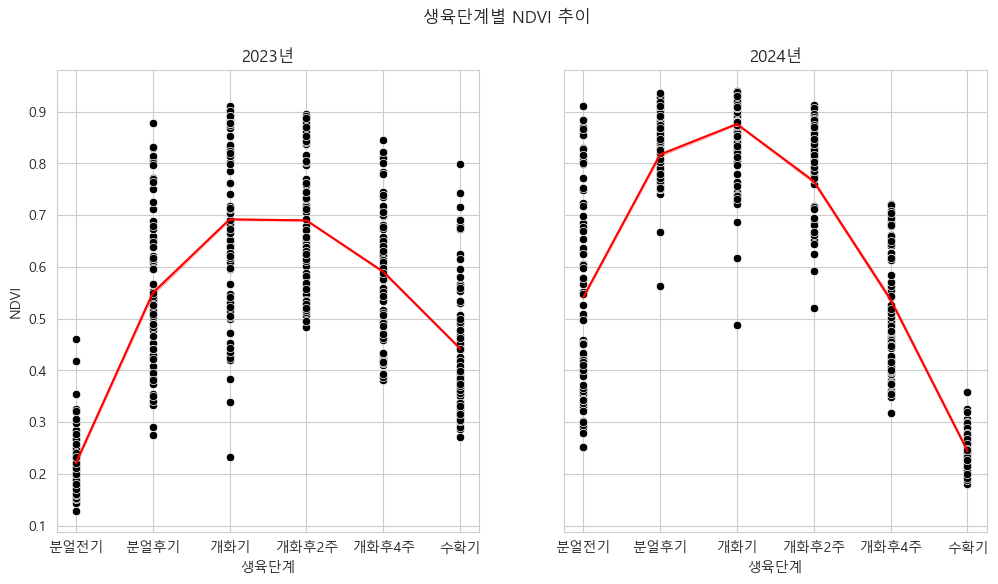

In [5]:
y_feature_name = 'NDVI'
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

for i, year in enumerate([2023, 2024]):
    ax = axes[i]
    df_target = df[df['year'] == year]
    poly_values = polynomial_regression(df_target, '생육단계_숫자', y_feature_name, 3)
    poly_series = df_target['생육단계_숫자'].apply(lambda x: x * poly_values[1] + x ** 2 * poly_values[2] + x ** 3 * poly_values[3] + poly_values[0])
    sns.scatterplot(x='생육단계', y=y_feature_name, data=df_target, color='black', ax=ax);
    sns.lineplot(x='생육단계', y=poly_series, data=df_target, color='red', ax=ax);
    ax.set_title(f'{year}년')

fig.suptitle(f'생육단계별 {y_feature_name} 추이');